In [150]:
import os
import json
import torch
import nltk

import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from torch import nn
from collections import Counter
from PIL import Image
from string import punctuation
from tqdm import tqdm
from gensim import corpora
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from keras.utils import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from torchvision.models import resnet101, ResNet101_Weights
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

pd.set_option('display.max_colwidth', None)


### Load the vector representations for words embeddings

In [151]:
import requests
import zipfile
import os

# Define the URL and local filename
url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip"
local_filename = "glove.6B.zip"

# Download the file
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# Unzip the file
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall(".")

# List files with detailed information
files = os.listdir(".")
files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
for file in files:
    print(f"{os.path.getmtime(file):.0f} {file}")


1716278190 glove.6B.50d.txt
1716278188 glove.6B.300d.txt
1716278181 glove.6B.200d.txt
1716278175 glove.6B.100d.txt
1716278173 glove.6B.zip
1716270786 decoder.pth
1716270786 encoder.pth
1716261737 .virtual_documents


### Load the dataset(Text File)

In [152]:
image_path = "./Flicker8k_Dataset"
df = pd.read_csv("./caption.txt",sep='\t', names=["image", "caption"], header=None)
df

image  \
0      1000268201_693b08cb0e.jpg#0   
1      1000268201_693b08cb0e.jpg#1   
2      1000268201_693b08cb0e.jpg#2   
3      1000268201_693b08cb0e.jpg#3   
4      1000268201_693b08cb0e.jpg#4   
...                            ...   
40455   997722733_0cb5439472.jpg#0   
40456   997722733_0cb5439472.jpg#1   
40457   997722733_0cb5439472.jpg#2   
40458   997722733_0cb5439472.jpg#3   
40459   997722733_0cb5439472.jpg#4   

                                                                           caption  
0         A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                            A girl going into a wooden building .  
2                                 A little girl climbing into a wooden playhouse .  
3                             A little girl climbing the stairs to her playhouse .  
4                        A little girl in a pink dress going into a wooden cabin .  
...                                                                            ...  
40455                                     A man in a pink shirt climbs a rock face  
40456                                     A man is rock climbing high in the air .  
40457  A person in a red shirt climbing up a rock face covered in assist handles .  
40458                                              A rock climber in a red shirt .  
40459                           A rock climber practices on a rock climbing wall .  

[40460 rows x 2 columns]

In [153]:
# Chaeck the unique images in the text file
df["image"].nunique()


40460

We can see here 1 image associated with 5 captions

In [154]:
# Remove the #number part from the image column
df['image'] = df['image'].str.split('#').str[0]

# Display the first few rows to verify
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .  
3                      A little girl climbing the stairs to her playhouse .  
4                 A little girl in a pink dress going into a wooden cabin .

In [155]:
# Remove anything after .jpg in the image column
df['image'] = df['image'].str.split('.jpg').str[0] + '.jpg'

In [156]:
import os
import pandas as pd

# Path to the image folder and the text file
image_folder = "./Flicker8k_Dataset"

# Read the image file names from the image folder
image_files = set(os.listdir(image_folder))

# Filter the DataFrame to keep only the rows where the image file names are present in the image folder
df = df[df['image'].isin(image_files)]


In [157]:
df.shape

(40455, 2)

In [158]:
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .  
3                      A little girl climbing the stairs to her playhouse .  
4                 A little girl in a pink dress going into a wooden cabin .

In [159]:
df["image"].nunique()

8091

The total number of unique images are 8091, and 1 image appears 4-5 times in the text dataset that means 1 image have 4-5 captions

In [160]:
vocab,embeddings = [],[]
with open('./glove.6B.100d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
print(full_content[0])
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062



The code reads GloVe embeddings from a file, extracts words and their corresponding embeddings, and stores them in the vocab and embeddings lists respectively.In this context, vocab contains a list of words (vocabulary) from the GloVe embeddings file, and embeddings contains the corresponding word vectors (numerical representations) for each word in vocab.

In [161]:
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
vocab_npa = np.insert(vocab_npa, 2, '<start>')
vocab_npa = np.insert(vocab_npa, 3, '<end>')
pad_emb_npa = np.zeros((1,embs_npa.shape[1]))
start_emb_npa = np.random.rand(1,embs_npa.shape[1])
end_emb_npa = np.random.rand(1,embs_npa.shape[1])
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,start_emb_npa,end_emb_npa,embs_npa))

The code converts the `vocab` and `embeddings` lists into numpy arrays, adds special tokens (`<pad>`, `<unk>`, `<start>`, `<end>`) to the vocabulary array, and inserts corresponding embeddings for these tokens into the embeddings array. Specifically:

1. `vocab_npa` is the numpy array of vocabulary words.
2. `embs_npa` is the numpy array of word embeddings.
3. Four special tokens (`<pad>`, `<unk>`, `<start>`, `<end>`) are inserted into the vocabulary array at specific positions.
4. Embeddings for these special tokens are created:
   - `<pad>` is assigned a zero vector.
   - `<start>` and `<end>` are assigned random vectors.
   - `<unk>` is assigned the mean of all existing embeddings.
5. These special embeddings are then inserted at the beginning of the embeddings array.

In [162]:
# Display images with the captions
def show_image_and_its_caption(index):
    image_name = df.iloc[index]["image"]
    captions = df[df["image"] == image_name]["caption"].tolist()
    
    img = mpimg.imread(os.path.join(image_path, image_name))
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()
    
    for caption in captions:
        print(caption)


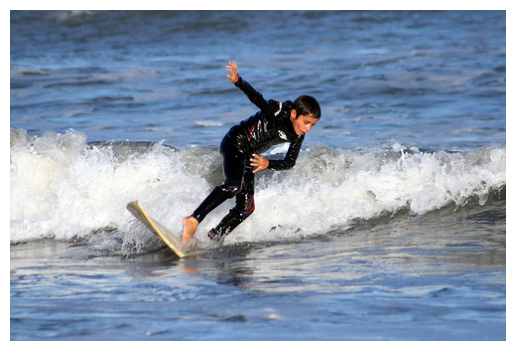

A child in a black wetsuit is in the waves on a surfboard .
A kid on a surfboard riding a small wave .
A small boy in black is surfing .
A young boy in a black wetsuit surfs in the water .
A young surfer rides a wave .


In [163]:
# Example usage
show_image_and_its_caption(6730)

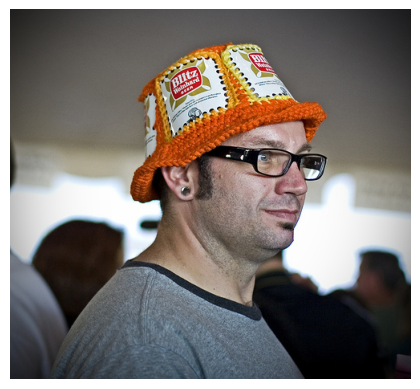

A man in an orange hat starring at something .
A man wears an orange hat and glasses .
A man with gauges and glasses is wearing a Blitz hat .
A man with glasses is wearing a beer can crocheted hat .
The man with pierced ears is wearing glasses and an orange hat .


In [164]:
show_image_and_its_caption(20)

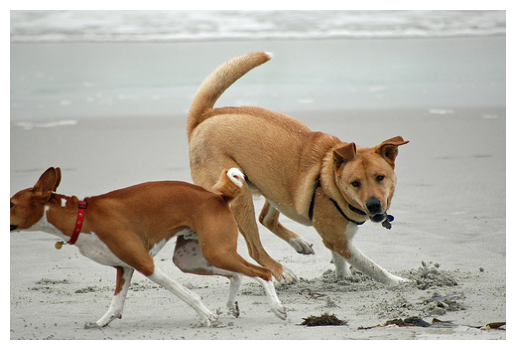

Two different breeds of brown and white dogs play on the beach .
Two dogs are making a turn on a soft sand beach .
Two dogs playing in the sand at the beach .
Two dogs playing together on a beach .
Two large tan dogs play along a sandy beach .


In [165]:
show_image_and_its_caption(101)

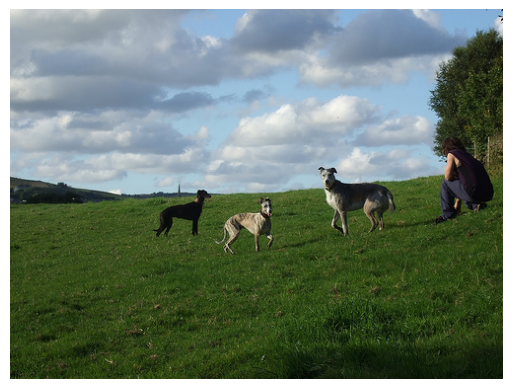

A woman crouches near three dogs in a field .
Three dogs are playing on grassy hill with a blue sky .
Three dogs are standing in the grass and a person is sitting next to them
Three dogs on a grassy hill
Three dogs stand in a grassy field while a person kneels nearby .


In [166]:
show_image_and_its_caption(141)

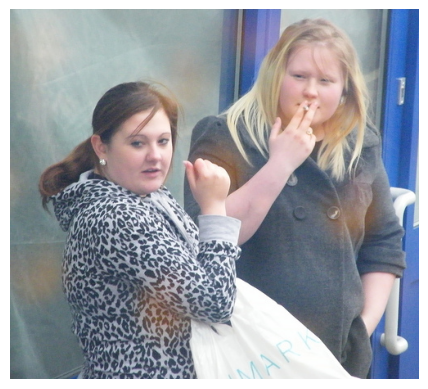

A woman in a animal print coat standing next to a smoking woman .
Two women are standing and one of them is smoking .
Two women outside and one is smoking
Two young women standing outside a blue door , one smoking a cigarette .
Tw woman stand outside a building , and one is smoking .


In [167]:
show_image_and_its_caption(6332)

In [168]:
unique_words = Counter()
df["tokens"] = None
max_caption_len = 30
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    words = nltk.word_tokenize(row["caption"])
    words = [word.lower() for word in words if word.isalpha() and word not in punctuation]
    if len(words) <= max_caption_len:
        df.at[index, "tokens"] = words
    else:
        df = df.drop(index)
        continue
    unique_words.update(words)

/tmp/ipykernel_34/2037992825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"] = None
100%|██████████| 40455/40455 [00:12<00:00, 3342.80it/s]


The code tokenizes captions in a DataFrame, filters out non-alphabetic tokens and punctuation, updates the DataFrame with valid token lists, and tracks unique word counts, dropping rows with captions exceeding the maximum length.

In [169]:
min_word_freq = 20
words = [w for w in unique_words.keys() if unique_words[w] > min_word_freq]
word_map = {k: v+1 for v, k in enumerate(words)}
word_map["<unk>"] = len(word_map) + 1
word_map["<start>"] = len(word_map) + 1
word_map["<end>"] = len(word_map) + 1
word_map["<pad>"] = 0
len(unique_words), len(words), len(word_map)

(8369, 1244, 1248)

The code filters words by a minimum frequency, creates a dictionary mapping these words and special tokens to unique indices, and then displays the lengths of the original unique words, the filtered words, and the word map.

In [170]:
# Create a sorted word map and gather corresponding embeddings in order
embeddings_focus = []
keys = list(word_map.keys())
values = list(word_map.values())
sorted_value_index = np.argsort(values)
sorted_word_map = {keys[i]: values[i] for i in sorted_value_index}
for key, value in sorted_word_map.items():
    index = np.where(vocab_npa == key)[0][0]
    embedding = embs_npa[index]
    embeddings_focus.append(embedding)
embeddings_focus = np.array(embeddings_focus)


This code sorts word_map by its values, retrieves embeddings for each word in the sorted order, and stores them in embeddings_focus.

In [171]:
index_to_word = {}
for k, v in sorted_word_map.items():
    index_to_word[v] = k

In [172]:
# print all the token and it's numeric form
index_to_word

{0: '<pad>',
 1: 'a',
 2: 'child',
 3: 'in',
 4: 'pink',
 5: 'dress',
 6: 'is',
 7: 'climbing',
 8: 'up',
 9: 'set',
 10: 'of',
 11: 'stairs',
 12: 'an',
 13: 'way',
 14: 'girl',
 15: 'going',
 16: 'into',
 17: 'wooden',
 18: 'building',
 19: 'little',
 20: 'the',
 21: 'to',
 22: 'her',
 23: 'black',
 24: 'dog',
 25: 'and',
 26: 'spotted',
 27: 'are',
 28: 'fighting',
 29: 'playing',
 30: 'with',
 31: 'each',
 32: 'other',
 33: 'on',
 34: 'road',
 35: 'white',
 36: 'brown',
 37: 'spots',
 38: 'staring',
 39: 'at',
 40: 'street',
 41: 'two',
 42: 'dogs',
 43: 'different',
 44: 'looking',
 45: 'pavement',
 46: 'moving',
 47: 'toward',
 48: 'covered',
 49: 'paint',
 50: 'sits',
 51: 'front',
 52: 'painted',
 53: 'rainbow',
 54: 'hands',
 55: 'bowl',
 56: 'sitting',
 57: 'large',
 58: 'small',
 59: 'grass',
 60: 'plays',
 61: 'it',
 62: 'there',
 63: 'painting',
 64: 'young',
 65: 'outside',
 66: 'man',
 67: 'lays',
 68: 'bench',
 69: 'while',
 70: 'his',
 71: 'by',
 72: 'him',
 73: 'which

In [173]:
df["caption_encoded"] = None
df["caption_length"] = None
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    words = row["tokens"]
    encoded_caption = [word_map["<start>"]] + [word_map.get(word, word_map["<unk>"]) for word in words] + [
        word_map["<end>"]] + [word_map["<pad>"]]*(max_caption_len - len(words))
    df.at[index, "caption_encoded"] = encoded_caption
    df.at[index, "caption_length"] = len(words) + 2

100%|██████████| 40446/40446 [00:04<00:00, 9250.59it/s]


In [174]:
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                                    caption  \
0  A child in a pink dress is climbing up a set of stairs in an entry way .   
1                                     A girl going into a wooden building .   
2                          A little girl climbing into a wooden playhouse .   
3                      A little girl climbing the stairs to her playhouse .   
4                 A little girl in a pink dress going into a wooden cabin .   

                                                                                     tokens  \
0  [a, child, in, a, pink, dress, is, climbing, up, a, set, of, stairs, in, an, entry, way]   
1                                               [a, girl, going, into, a, wooden, building]   
2                                   [a, little, girl, climbing, into, a, wooden, playhouse]   
3                              [a, little, girl, climbing, the, stairs, to, her, playhouse]   
4                      [a, little, girl, in, a, pink, dress, going, into, a, wooden, cabin]   

                                                                                                   caption_encoded  \
0    [1246, 1, 2, 3, 1, 4, 5, 6, 7, 8, 1, 9, 10, 11, 3, 12, 1245, 13, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1      [1246, 1, 14, 15, 16, 1, 17, 18, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2    [1246, 1, 19, 14, 7, 16, 1, 17, 1245, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3  [1246, 1, 19, 14, 7, 20, 11, 21, 22, 1245, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
4   [1246, 1, 19, 14, 3, 1, 4, 5, 15, 16, 1, 17, 1245, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

  caption_length  
0             19  
1              9  
2             10  
3             11  
4             14

In [175]:
df_ = df.groupby("image").apply(lambda x: x.sample(n=4) if x.shape[0] >= 4 else None).reset_index(drop=True)

/tmp/ipykernel_34/2541336336.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ = df.groupby("image").apply(lambda x: x.sample(n=4) if x.shape[0] >= 4 else None).reset_index(drop=True)


In [176]:
df_.shape

(32364, 5)

In [177]:
df_.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1001773457_577c3a7d70.jpg   

                                                                    caption  \
0                      A little girl climbing the stairs to her playhouse .   
1  A child in a pink dress is climbing up a set of stairs in an entry way .   
2                          A little girl climbing into a wooden playhouse .   
3                 A little girl in a pink dress going into a wooden cabin .   
4          Two dogs of different breeds looking at each other on the road .   

                                                                                     tokens  \
0                              [a, little, girl, climbing, the, stairs, to, her, playhouse]   
1  [a, child, in, a, pink, dress, is, climbing, up, a, set, of, stairs, in, an, entry, way]   
2                                   [a, little, girl, climbing, into, a, wooden, playhouse]   
3                      [a, little, girl, in, a, pink, dress, going, into, a, wooden, cabin]   
4               [two, dogs, of, different, breeds, looking, at, each, other, on, the, road]   

                                                                                                        caption_encoded  \
0       [1246, 1, 19, 14, 7, 20, 11, 21, 22, 1245, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1         [1246, 1, 2, 3, 1, 4, 5, 6, 7, 8, 1, 9, 10, 11, 3, 12, 1245, 13, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2         [1246, 1, 19, 14, 7, 16, 1, 17, 1245, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3        [1246, 1, 19, 14, 3, 1, 4, 5, 15, 16, 1, 17, 1245, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
4  [1246, 41, 42, 10, 43, 1245, 44, 39, 31, 32, 33, 20, 34, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

  caption_length  
0             11  
1             19  
2             10  
3             14  
4             14

In [178]:
# Image encoder using ResNet-101, with optional fine-tuning and adaptive pooling to a specified size
class ImageEncoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super().__init__()
        self.resnet101 = resnet101(pretrained=True)
        modules = list(self.resnet101.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pooling = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune()
    def forward(self, image):
        x = self.resnet(image)
        x = self.adaptive_pooling(x)
        x = x.permute(0, 2, 3, 1)
        return x
    def fine_tune(self, fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = False
        for layer in list(self.resnet.children())[5:]:
            for p in layer.parameters():
                p.requires_grad = fine_tune


This code defines an image encoder using a pre-trained ResNet-101, applies adaptive pooling, and optionally fine-tunes certain layers.

In [179]:
# Attention mechanism module for computing attention weights and weighted encodings
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)
        self.aggregate = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
    def forward(self, encoder_out, decoder_out):
        encoder_attn = self.encoder_attn(encoder_out)
        decoder_attn = self.decoder_attn(decoder_out)
        attention = self.aggregate(self.relu(encoder_attn + decoder_attn.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(attention)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha


This code implements an attention mechanism using linear layers and softmax to compute attention weights and weighted encodings.

In [180]:
# Decoder with attention mechanism for generating captions from encoded image features
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder_dim, attention_dim, embed_dim, vocab_size, dropout=0.5, encoder_dim=2048):
        super().__init__()
        # Initialize decoder parameters
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        
        # Embedding layer for word embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings_focus).float())
        # Attention mechanism
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        # LSTM cell
        self.lstmcell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        # Linear layer for classification
        self.classification = nn.Linear(decoder_dim, vocab_size)
        # Linear layer for gating mechanism
        self.f_gate = nn.Linear(decoder_dim, encoder_dim)
        # Linear layers for initializing LSTM hidden and cell states
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.dropout_layer = nn.Dropout(self.dropout)
        # Enable fine-tuning of embeddings
        self.fine_tune_embeddings()
    
    def init_h_init_c(self, encoder_out):
        # Initialize LSTM hidden and cell states based on encoder outputs
        h = self.init_h(encoder_out).mean(dim=1)
        c = self.init_c(encoder_out).mean(dim=1)
        return h, c

    def fine_tune_embeddings(self):
        # Enable fine-tuning of embeddings
        for p in self.embedding.parameters():
            p.requires_grad = True
        
    def forward(self, encoder_out, encoded_captions, captions_length):
        # Forward pass of the decoder
        batch_size = encoder_out.size()[0]
        encoder_out = encoder_out.view(encoder_out.size()[0], -1, encoder_out.size()[-1])
        captions_length, sort_ind = captions_length.squeeze(1).sort(dim=0, descending=True)
        encoded_captions = encoded_captions[sort_ind]
        encoder_out = encoder_out[sort_ind]
        embeddings = self.embedding(encoded_captions)
        h, c = self.init_h_init_c(encoder_out)
        decoder_sequence_length = (captions_length - 1).tolist()
        num_pixels = encoder_out.size()[1]
        predictions = torch.zeros(batch_size, max(decoder_sequence_length), self.vocab_size).to(device)
        images = torch.zeros(batch_size, max(decoder_sequence_length), num_pixels).to(device)
        
        for i in range(max(decoder_sequence_length)):
            batch_size_i = sum([l > i for l in decoder_sequence_length])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_i], h[:batch_size_i])
            gate = self.sigmoid(self.f_gate(h[:batch_size_i]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.lstmcell(torch.cat([embeddings[:batch_size_i, i, :],attention_weighted_encoding], dim=1),
                                 (h[:batch_size_i], c[:batch_size_i]))
            preds = self.classification(self.dropout_layer(h))
            predictions[:batch_size_i, i, :] = preds
            images[:batch_size_i, i, :] = alpha
        return predictions, images, sort_ind, encoded_captions, decoder_sequence_length


This code defines a decoder with attention mechanism to generate captions from encoded image features, incorporating LSTM, attention, and classification layers.

In [181]:
# Dataset loader for image captioning, loading image tensors and encoded captions
class CaptionDataLoader(Dataset):
    def __init__(self, df, image_path, dataset="TRAIN", transform=None):
        super().__init__()
        self.image_ids = df["image"].to_list()
        self.caption_encoded = df["caption_encoded"].to_list()
        self.caption_lengths = df["caption_length"].to_list()
        self.image_path = image_path
        self.dataset = dataset
        self.transform = transform
    def __len__(self):
        return len(self.image_ids)
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.image_path, self.image_ids[index]))
        new_image = img.resize((224, 224))
        np_image = np.array(new_image).astype('float32')/255
        np_image = np.expand_dims(np_image, axis=0)
        image_tensor = torch.transpose(torch.from_numpy(np_image), 1, 3)
        image_tensor = image_tensor.squeeze(0)
        if self.transform is not None:
            image_tensor = self.transform(image_tensor)
        encoded_captions = torch.tensor(self.caption_encoded[index])
        captions_length = torch.tensor(np.array([self.caption_lengths[index]]))
        if self.dataset == "TRAIN":
            return image_tensor, encoded_captions, captions_length
        else:
            all_indices = np.where(np.array(self.image_ids) == self.image_ids[index])[0]
            all_captions = torch.tensor(np.take(self.caption_encoded, all_indices, axis=0))
            return image_tensor, encoded_captions, captions_length, all_captions

This class is a custom dataset loader designed to handle image captioning tasks. It loads image tensors and their corresponding encoded captions from a DataFrame, with the option to apply transformations to the images. Additionally, it can distinguish between training and testing datasets and return different types of data accordingly.








In [182]:
# Split the dataset into Train, Test and validations
image_ids = df_["image"].unique()

# Correct the split indices to achieve 80%, 10%, 10%
train_size = int(0.7 * len(image_ids))
validate_size = int(0.2 * len(image_ids))

train, validate, test = np.split(image_ids, [train_size, train_size + validate_size])

# Filter the dataframe based on the splits
df_train = df_[df_["image"].isin(train)]
df_validate = df_[df_["image"].isin(validate)]
df_test = df_[df_["image"].isin(test)]

print("train len:", len(df_train))
print("validate len:", len(df_validate))
print("test len:", len(df_test))


train len: 22652
validate len: 6472
test len: 3240


In [183]:
# Prepare data loaders for training and validation, applying normalization to images
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# Define data loaders for training and validation datasets
train_loader = CaptionDataLoader(df_train, image_path, transform=transforms.Compose([normalize]))
train_data_loader = DataLoader(train_loader, batch_size=32, num_workers=4, shuffle=True)
valid_loader = CaptionDataLoader(df_validate, image_path, dataset="VAL", transform=transforms.Compose([normalize]))
valid_data_loader = DataLoader(valid_loader, batch_size=32, num_workers=4, shuffle=True)
# Iterate over the validation data loader to check the size of batches
for image, caption, length, all_caps in valid_data_loader:
    print(image.size())
    print(caption.size())
    print(length.size())
    print(all_caps.size())
    break


torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 1])
torch.Size([32, 4, 32])


This code prepares data loaders for training and validation datasets in an image captioning task, applying normalization to images and checking the size of batches in the validation dataset.

In [34]:
# Utility functions for computing accuracy, clipping gradients, and tracking average metrics
class AverageMeter:
    # Computes and tracks the average value of a metric
    def __init__(self):
        self.reset()

    def reset(self):
        # Reset the meter to its initial state
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        # Update the meter with a new value and compute the average
        self.sum += val
        self.count += n
        self.avg = self.sum / self.count

# Computes accuracy of model predictions
def accuracy(scores, targets, k):
    # Returns the accuracy of the top-k predictions
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum() 
    return correct_total.item()

# Clipping gradients to prevent exploding gradients problem
def clip_gradient(optimizer, grad_clip):
    # Clips gradients to prevent them from exceeding a threshold
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


This code defines utility functions for computing accuracy, clipping gradients, and tracking average metrics. The AverageMeter class is used to compute and track the average value of a metric, while the accuracy function calculates the accuracy of model predictions. 

In [35]:
# ----------------------------------------------Training process start----------------------------------------------

from torchvision.models import vgg19, VGG19_Weights
embed_dim = 100
attention_dim = 512
decoder_dim = 512
device = "cuda" if torch.cuda.is_available() else "cpu"
start_epoch = 0
num_epochs = 15
encoder_lr = 1e-4
decoder_lr = 5e-4
fine_tune_encoder = True
grad_clip = 5

decoder = DecoderWithAttention(
    decoder_dim=decoder_dim, embed_dim=embed_dim, vocab_size=len(word_map), attention_dim=attention_dim)

decoder_optim = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

encoder = ImageEncoder()
encoder.fine_tune()
encoder_optim = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr)

decoder.to(device)
encoder.to(device)
criterion = torch.nn.CrossEntropyLoss().cuda()
best_loss = np.inf

for i in range(num_epochs):
    encoder.train()
    decoder.train()
    train_losses = AverageMeter()
    train_top5accs = AverageMeter()

    for image, captions, caption_length in tqdm(train_data_loader, total=len(train_data_loader)):
        image = image.to(device)
        captions = captions.to(device)
        caption_length = caption_length.to(device)
        
        encoder_out = encoder(image)
        predictions, images, sort_ind, encoded_captions, decoder_sequence_length = decoder(encoder_out, captions, caption_length)
        
        targets = encoded_captions[:, 1:]
        
        scores, _, _, _ = pack_padded_sequence(predictions, decoder_sequence_length, batch_first=True)
        targets, _, _, _ = pack_padded_sequence(targets, decoder_sequence_length, batch_first=True)
        
        loss = criterion(scores, targets)
        train_losses.update(loss, sum(decoder_sequence_length))
        top5 = accuracy(scores, targets, 5)
        train_top5accs.update(top5, sum(decoder_sequence_length))
        
        decoder_optim.zero_grad()
        encoder_optim.zero_grad()
        loss.backward()
        clip_gradient(decoder_optim, grad_clip)
        clip_gradient(encoder_optim, grad_clip)
        decoder_optim.step()
        encoder_optim.step()
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        losses = AverageMeter()
        top5accs = AverageMeter()
        all_true_captions = list()
        predicted_captions = list()

        for image, captions, caption_length, all_captions in tqdm(valid_data_loader, total=len(valid_data_loader)):
            image = image.to(device)
            captions = captions.to(device)
            caption_length = caption_length.to(device)
            all_captions = all_captions.to(device)
            
            encoder_out = encoder(image)
            predictions, images, sort_ind, encoded_captions, decoder_sequence_length = decoder(encoder_out, captions, caption_length)
            
            targets = encoded_captions[:, 1:]
            scores_copy = predictions.clone()
            
            scores, _, _, _ = pack_padded_sequence(predictions, decoder_sequence_length, batch_first=True)
            targets, _, _, _ = pack_padded_sequence(targets, decoder_sequence_length, batch_first=True)
            
            loss = criterion(scores, targets)
            losses.update(loss, sum(decoder_sequence_length))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decoder_sequence_length))
            
            # Processing true and predicted captions for BLEU score calculation
            all_captions = all_captions[sort_ind]
            all_captions = all_captions.tolist()
            
            for caps in all_captions:
                cur_caps = [list(filter(lambda w: w not in {word_map["<start>"], word_map["<pad>"], word_map["<end>"]}, c)) for c in caps]
                all_true_captions.append(cur_caps)
            
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = []
            
            for j, p in enumerate(preds):
                pred = [w for w in p if w != word_map["<pad>"]]
                temp_preds.append(pred)
                
            predicted_captions.extend(temp_preds)
        
        assert len(all_true_captions) == len(predicted_captions)
        
        bleu1 = corpus_bleu(all_true_captions, predicted_captions, weights=(1, 0, 0, 0))
        bleu2 = corpus_bleu(all_true_captions, predicted_captions, weights=(0.5, 0.5, 0, 0))
        bleu3 = corpus_bleu(all_true_captions, predicted_captions, weights=(0.33, 0.33, 0.33, 0))
        bleu4 = corpus_bleu(all_true_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25))
        
        if losses.val < best_loss:
            best_loss = losses.val
            state_dict_encoder = encoder.state_dict()
            state_dict_decoder = decoder.state_dict()
            
    print(f"Epoch {i+1}, Train loss = {round(float(train_losses.avg), 4)}, Train Top5 Accuracy = {round(float(train_top5accs.avg), 4)}, Valid loss = {round(float(losses.avg), 4)}, Valid Top5 Accuracy = {round(float(top5accs.avg), 4)}, BLEU-1 = {round(float(bleu1), 4)}, BLEU-2 = {round(float(bleu2), 4)}, BLEU-3 = {round(float(bleu3), 4)}, BLEU-4 = {round(float(bleu4), 4)}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 116MB/s]  
  0%|          | 0/708 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Chan

Epoch 1, Train loss = 0.0104, Train Top5 Accuracy = 0.5126, Valid loss = 0.009, Valid Top5 Accuracy = 0.591, BLEU-1 = 0.5052, BLEU-2 = 0.2904, BLEU-3 = 0.149, BLEU-4 = 0.0738


100%|██████████| 203/203 [01:30<00:00,  2.24it/s]


Epoch 2, Train loss = 0.0084, Train Top5 Accuracy = 0.621, Valid loss = 0.0082, Valid Top5 Accuracy = 0.6272, BLEU-1 = 0.5246, BLEU-2 = 0.3103, BLEU-3 = 0.1634, BLEU-4 = 0.0842


100%|██████████| 203/203 [01:29<00:00,  2.27it/s]


Epoch 3, Train loss = 0.0076, Train Top5 Accuracy = 0.66, Valid loss = 0.0079, Valid Top5 Accuracy = 0.65, BLEU-1 = 0.5432, BLEU-2 = 0.3245, BLEU-3 = 0.1781, BLEU-4 = 0.0969


100%|██████████| 203/203 [01:30<00:00,  2.24it/s]


Epoch 4, Train loss = 0.0072, Train Top5 Accuracy = 0.6874, Valid loss = 0.0076, Valid Top5 Accuracy = 0.6608, BLEU-1 = 0.5421, BLEU-2 = 0.3257, BLEU-3 = 0.1793, BLEU-4 = 0.0974


100%|██████████| 203/203 [01:29<00:00,  2.26it/s]


Epoch 5, Train loss = 0.0068, Train Top5 Accuracy = 0.7103, Valid loss = 0.0075, Valid Top5 Accuracy = 0.6678, BLEU-1 = 0.5482, BLEU-2 = 0.3298, BLEU-3 = 0.1824, BLEU-4 = 0.0993


100%|██████████| 203/203 [01:28<00:00,  2.28it/s]


Epoch 6, Train loss = 0.0065, Train Top5 Accuracy = 0.728, Valid loss = 0.0074, Valid Top5 Accuracy = 0.6743, BLEU-1 = 0.5533, BLEU-2 = 0.3371, BLEU-3 = 0.1891, BLEU-4 = 0.1047


100%|██████████| 203/203 [01:28<00:00,  2.30it/s]


Epoch 7, Train loss = 0.0062, Train Top5 Accuracy = 0.7449, Valid loss = 0.0074, Valid Top5 Accuracy = 0.6779, BLEU-1 = 0.5475, BLEU-2 = 0.3348, BLEU-3 = 0.191, BLEU-4 = 0.1072


100%|██████████| 203/203 [01:29<00:00,  2.28it/s]


Epoch 8, Train loss = 0.006, Train Top5 Accuracy = 0.761, Valid loss = 0.0074, Valid Top5 Accuracy = 0.6794, BLEU-1 = 0.5514, BLEU-2 = 0.3379, BLEU-3 = 0.193, BLEU-4 = 0.1087


100%|██████████| 203/203 [01:28<00:00,  2.29it/s]


Epoch 9, Train loss = 0.0057, Train Top5 Accuracy = 0.7764, Valid loss = 0.0074, Valid Top5 Accuracy = 0.6795, BLEU-1 = 0.5485, BLEU-2 = 0.3366, BLEU-3 = 0.1926, BLEU-4 = 0.1079


100%|██████████| 203/203 [01:28<00:00,  2.29it/s]


Epoch 10, Train loss = 0.0055, Train Top5 Accuracy = 0.7893, Valid loss = 0.0074, Valid Top5 Accuracy = 0.6789, BLEU-1 = 0.5532, BLEU-2 = 0.3361, BLEU-3 = 0.1906, BLEU-4 = 0.1064


100%|██████████| 203/203 [01:28<00:00,  2.29it/s]


Epoch 11, Train loss = 0.0053, Train Top5 Accuracy = 0.8022, Valid loss = 0.0075, Valid Top5 Accuracy = 0.6769, BLEU-1 = 0.556, BLEU-2 = 0.3389, BLEU-3 = 0.1935, BLEU-4 = 0.1086


100%|██████████| 203/203 [01:29<00:00,  2.27it/s]


Epoch 12, Train loss = 0.0051, Train Top5 Accuracy = 0.8151, Valid loss = 0.0075, Valid Top5 Accuracy = 0.6775, BLEU-1 = 0.5509, BLEU-2 = 0.3331, BLEU-3 = 0.1891, BLEU-4 = 0.1064


100%|██████████| 203/203 [01:28<00:00,  2.29it/s]


Epoch 13, Train loss = 0.0049, Train Top5 Accuracy = 0.8273, Valid loss = 0.0076, Valid Top5 Accuracy = 0.6763, BLEU-1 = 0.5565, BLEU-2 = 0.3397, BLEU-3 = 0.1954, BLEU-4 = 0.1107


100%|██████████| 203/203 [01:28<00:00,  2.29it/s]


Epoch 14, Train loss = 0.0046, Train Top5 Accuracy = 0.8393, Valid loss = 0.0076, Valid Top5 Accuracy = 0.6716, BLEU-1 = 0.5469, BLEU-2 = 0.3317, BLEU-3 = 0.19, BLEU-4 = 0.1076


100%|██████████| 203/203 [01:28<00:00,  2.28it/s]


Epoch 15, Train loss = 0.0045, Train Top5 Accuracy = 0.8502, Valid loss = 0.0077, Valid Top5 Accuracy = 0.6717, BLEU-1 = 0.5481, BLEU-2 = 0.3293, BLEU-3 = 0.1876, BLEU-4 = 0.1048


In [47]:
# Save the trained model (Encoder, Decoder)
torch.save(state_dict_encoder, "encoder.pth")
torch.save(state_dict_decoder, "decoder.pth")

In [48]:
# Load the trained model (Encoder, Decoder)
encoder.load_state_dict(state_dict_encoder)
decoder.load_state_dict(state_dict_decoder)
encoder.to(device)
decoder.to(device)

DecoderWithAttention(
  (embedding): Embedding(1248, 100)
  (attention): Attention(
    (encoder_attn): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_attn): Linear(in_features=512, out_features=512, bias=True)
    (aggregate): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=None)
  )
  (lstmcell): LSTMCell(2148, 512)
  (classification): Linear(in_features=512, out_features=1248, bias=True)
  (f_gate): Linear(in_features=512, out_features=2048, bias=True)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (sigmoid): Sigmoid()
  (dropout_layer): Dropout(p=0.5, inplace=False)
)

In [49]:
# Build and prepare the test data loader for test with the trained model
test_loader = CaptionDataLoader(df_test, dataset="TEST", image_path=image_path)
test_data_loader = DataLoader(test_loader, batch_size=1, num_workers=1)

In [50]:
# Compute the test accuracy, test loss, BLUE1,2,3,4 scores using the trained model. 
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    test_losses = AverageMeter()
    test_top5accs = AverageMeter()
    all_true_captions = []
    predicted_captions = []

    for image, captions, caption_length, all_captions in tqdm(test_data_loader, total=len(test_data_loader)):
        image = image.to(device)
        captions = captions.to(device)
        caption_length = caption_length.to(device)
        all_captions = all_captions.to(device)

        encoder_out = encoder(image)
        predictions, images, sort_ind, encoded_captions, decoder_sequence_length = decoder(encoder_out, captions, caption_length)

        targets = encoded_captions[:, 1:]
        scores_copy = predictions.clone()

        scores, _, _, _ = pack_padded_sequence(predictions, decoder_sequence_length, batch_first=True)
        targets, _, _, _ = pack_padded_sequence(targets, decoder_sequence_length, batch_first=True)

        loss = criterion(scores, targets)
        test_losses.update(loss, sum(decoder_sequence_length))
        top5 = accuracy(scores, targets, 5)
        test_top5accs.update(top5, sum(decoder_sequence_length))

        # Processing true and predicted captions for BLEU score calculation
        all_captions = all_captions[sort_ind]
        all_captions = all_captions.tolist()

        for caps in all_captions:
            cur_caps = [list(filter(lambda w: w not in {word_map["<start>"], word_map["<pad>"], word_map["<end>"]}, c)) for c in caps]
            all_true_captions.append(cur_caps)

        _, preds = torch.max(scores_copy, dim=2)
        preds = preds.tolist()
        temp_preds = []

        for j, p in enumerate(preds):
            pred = [w for w in p if w != word_map["<pad>"]]
            temp_preds.append(pred)

        predicted_captions.extend(temp_preds)

    assert len(all_true_captions) == len(predicted_captions)

    bleu1 = corpus_bleu(all_true_captions, predicted_captions, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(all_true_captions, predicted_captions, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(all_true_captions, predicted_captions, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(all_true_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25))

print(f"Test loss = {round(float(test_losses.avg), 4)}, Test Top5 Accuracy = {round(float(test_top5accs.avg), 4)}, BLEU-1 = {round(float(bleu1), 4)}, BLEU-2 = {round(float(bleu2), 4)}, BLEU-3 = {round(float(bleu3), 4)}, BLEU-4 = {round(float(bleu4), 4)}")


100%|██████████| 3240/3240 [01:25<00:00, 37.96it/s]


Test loss = 0.2683, Test Top5 Accuracy = 0.6249, BLEU-1 = 0.5156, BLEU-2 = 0.2868, BLEU-3 = 0.1486, BLEU-4 = 0.0729


In [134]:
df_test.sample(5)

image  \
29426  458735196_176e7df6b3.jpg   
29892  488356951_b3b77ad832.jpg   
31385  696663662_232edd58af.jpg   
29279  446291803_2fd4641b99.jpg   
31916  862156271_3eacea90a8.jpg   

                                                                                        caption  \
29426                                               A wrinkled dog playing with a pink chew toy   
29892  These three men are sitting near each other , and are all wearing short sleeved shirts .   
31385                             A boy with his arm wrapped in an ACE bandage rests in a bed .   
29279         Two women sitting on a bench in front of a tennis court near a building complex .   
31916    Girls with orange hair standing on the street with some kind of bottle in their hand .   

                                                                                                      tokens  \
29426                                                  [a, wrinkled, dog, playing, with, a, pink, chew, toy]   
29892   [these, three, men, are, sitting, near, each, other, and, are, all, wearing, short, sleeved, shirts]   
31385                             [a, boy, with, his, arm, wrapped, in, an, ace, bandage, rests, in, a, bed]   
29279       [two, women, sitting, on, a, bench, in, front, of, a, tennis, court, near, a, building, complex]   
31916  [girls, with, orange, hair, standing, on, the, street, with, some, kind, of, bottle, in, their, hand]   

                                                                                                                      caption_encoded  \
29426               [1246, 1, 1245, 24, 29, 30, 1, 4, 1245, 192, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
29892  [1246, 772, 286, 235, 27, 56, 109, 31, 32, 25, 27, 568, 88, 632, 1245, 896, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
31385      [1246, 1, 125, 30, 70, 381, 1132, 3, 12, 1245, 1245, 488, 3, 1, 361, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
29279       [1246, 41, 625, 56, 33, 1, 68, 3, 51, 10, 1, 428, 1054, 109, 1, 18, 1245, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
31916  [1246, 354, 30, 83, 378, 122, 33, 20, 40, 30, 323, 1245, 10, 858, 3, 222, 212, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

      caption_length  
29426             11  
29892             17  
31385             16  
29279             18  
31916             18

In [184]:
# Text image id or name which can be used below
d1 = df_test[df_test["image"]=="527968666_1fcddf81ab.jpg"]
d1

image  \
30552  527968666_1fcddf81ab.jpg   
30553  527968666_1fcddf81ab.jpg   
30554  527968666_1fcddf81ab.jpg   
30555  527968666_1fcddf81ab.jpg   

                                                       caption  \
30552  The dog is on a leash and is walking out of the water .   
30553                 A wet black dog emerges from the water .   
30554     A black dog on a blue leash is walking in a stream .   
30555                  A black dog on a leash walking in water   

                                                                    tokens  \
30552  [the, dog, is, on, a, leash, and, is, walking, out, of, the, water]   
30553                      [a, wet, black, dog, emerges, from, the, water]   
30554      [a, black, dog, on, a, blue, leash, is, walking, in, a, stream]   
30555                    [a, black, dog, on, a, leash, walking, in, water]   

                                                                                                           caption_encoded  \
30552  [1246, 20, 24, 6, 33, 1, 81, 25, 6, 132, 305, 10, 20, 121, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
30553   [1246, 1, 255, 23, 24, 1245, 178, 20, 121, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
30554     [1246, 1, 23, 24, 33, 1, 139, 81, 6, 132, 3, 1, 537, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
30555       [1246, 1, 23, 24, 33, 1, 81, 132, 3, 121, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

      caption_length  
30552             15  
30553             10  
30554             14  
30555             11

In [185]:
# Text image id or name which can be used below
d2 = df_test[df_test["image"]=="485245061_5a5de43e20.jpg"]
d2

image  \
29820  485245061_5a5de43e20.jpg   
29821  485245061_5a5de43e20.jpg   
29822  485245061_5a5de43e20.jpg   
29823  485245061_5a5de43e20.jpg   

                                                                       caption  \
29820  A man in a green jacket stands in deep snow at the base of a mountain .   
29821                                               A man kneels in the snow .   
29822                                       A man measures the depth of snow .   
29823                  A mountain hiker is digging steaks into the thck snow .   

                                                                                       tokens  \
29820  [a, man, in, a, green, jacket, stands, in, deep, snow, at, the, base, of, a, mountain]   
29821                                                         [a, man, kneels, in, the, snow]   
29822                                                [a, man, measures, the, depth, of, snow]   
29823                        [a, mountain, hiker, is, digging, steaks, into, the, thck, snow]   

                                                                                                                caption_encoded  \
29820  [1246, 1, 66, 3, 1, 107, 246, 118, 3, 538, 153, 39, 20, 924, 10, 1, 407, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
29821              [1246, 1, 66, 291, 3, 20, 153, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
29822         [1246, 1, 66, 1245, 20, 1245, 10, 153, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
29823   [1246, 1, 407, 403, 6, 1075, 1245, 16, 20, 1245, 153, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

      caption_length  
29820             18  
29821              8  
29822              9  
29823             12

In [188]:
# Text image id or name which can be used below
d3 = df_test[df_test["image"]=="3440160917_4524cfd9f6.jpg"]
d3

image  \
30192  506343925_b30a235de6.jpg   
30193  506343925_b30a235de6.jpg   
30194  506343925_b30a235de6.jpg   
30195  506343925_b30a235de6.jpg   

                                                  caption  \
30192  A brown , white , and black dog runs in the sand .   
30193                    A wolf running in sandy plains .   
30194            A striped dog is running in the desert .   
30195                A wild dog runs through the desert .   

                                                        tokens  \
30192  [a, brown, white, and, black, dog, runs, in, the, sand]   
30193                    [a, wolf, running, in, sandy, plains]   
30194          [a, striped, dog, is, running, in, the, desert]   
30195               [a, wild, dog, runs, through, the, desert]   

                                                                                                          caption_encoded  \
30192    [1246, 1, 36, 35, 25, 23, 24, 108, 3, 20, 240, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
30193    [1246, 1, 1245, 100, 3, 243, 1245, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
30194     [1246, 1, 330, 24, 6, 100, 3, 20, 1146, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
30195  [1246, 1, 1245, 24, 108, 105, 20, 1146, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

      caption_length  
30192             12  
30193              8  
30194             10  
30195              9

In [187]:
# Text image id or name which can be used below
d4 = df_test[df_test["image"]=="544576742_283b65fa0d.jpg"]
d4

image  \
30900  544576742_283b65fa0d.jpg   
30901  544576742_283b65fa0d.jpg   
30902  544576742_283b65fa0d.jpg   
30903  544576742_283b65fa0d.jpg   

                                                                     caption  \
30900                                        A woman climbing a rock cliff .   
30901                                       A woman in jeans rock climbing .   
30902  The woman is holding onto a huge rock and has red string around her .   
30903                               A rock climber repels off a rocky wall .   

                                                                                   tokens  \
30900                                                [a, woman, climbing, a, rock, cliff]   
30901                                               [a, woman, in, jeans, rock, climbing]   
30902  [the, woman, is, holding, onto, a, huge, rock, and, has, red, string, around, her]   
30903                                     [a, rock, climber, repels, off, a, rocky, wall]   

                                                                                                                 caption_encoded  \
30900               [1246, 1, 202, 7, 1, 141, 165, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
30901               [1246, 1, 202, 3, 140, 141, 7, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
30902  [1246, 20, 202, 6, 80, 97, 1, 883, 141, 25, 254, 94, 1036, 209, 22, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
30903        [1246, 1, 141, 245, 1245, 120, 1, 385, 127, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

      caption_length  
30900              8  
30901              8  
30902             16  
30903             10

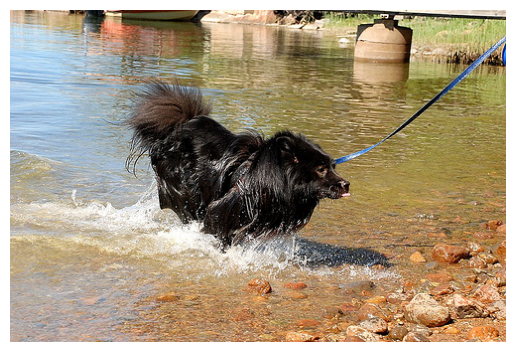

Generated Caption: a black dog is running through a field of water
Actual Captions:
- A black dog on a blue leash is walking in a stream .
- A wet black dog emerges from the water .
- The dog is on a leash and is walking out of the water .
- A black dog on a leash walking in water

BLEU-1: 0.7
BLEU-2: 0.3944053188733077
BLEU-3: 0.541155683081633
BLEU-4: 0.628016973395869


In [56]:
# Generate the captions with test image
def preprocess_image(image_path):
    """
    Preprocess the image to be suitable for the model input.

    :param image_path: Path to the image to preprocess
    :return: Preprocessed image tensor
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image

def get_actual_captions(image_path):
    """
    Get the actual captions from the test dataset based on the image path.

    :param image_path: Path to the image
    :return: List of actual captions as strings
    """
    filename = os.path.basename(image_path)
    filtered_df = df_test[df_test['image'] == filename]
    if filtered_df.empty:
        return None
    return filtered_df['caption'].tolist()

def generate_caption_and_evaluate(image_path):
    """
    Generate caption for an image, print actual and generated captions, compute BLEU scores, and display the image.

    :param image_path: Path to the image
    """
    # Load and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess the image
    img_tensor = preprocess_image(image_path).to(device)

    # Generate caption
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        encoder_out = encoder(img_tensor)
        feature_size = encoder_out.size(3)
        encoder_out = encoder_out.view(1, -1, feature_size)
        k_prev_words = torch.LongTensor([[word_map["<start>"]]]).to(device)
        seqs = k_prev_words
        h, c = decoder.init_h_init_c(encoder_out)
        step = 1
        while True:
            embeddings = decoder.embedding(k_prev_words).squeeze(1)
            attention_encoding, alpha = decoder.attention(encoder_out, h)
            gate = decoder.sigmoid(decoder.f_gate(h))
            attention_encoding = gate * attention_encoding
            h, c = decoder.lstmcell(torch.cat([embeddings, attention_encoding], dim=1), (h,c))
            output = decoder.classification(h)
            scores = nn.LogSoftmax(dim=1)(output)
            topk_scores, topk_words_ind = scores[0].topk(1, 0, True, True)
            prev_word_inds = topk_words_ind // len(word_map)
            next_word_inds = topk_words_ind % len(word_map)
            seqs = torch.cat([seqs, next_word_inds.unsqueeze(1)], dim = 1)
            if next_word_inds.item() == word_map["<end>"]:
                break
            k_prev_words = next_word_inds
            if step > 50:
                break
            step += 1

    generated_caption = [index_to_word[ind.item()] for ind in seqs.squeeze()]
    generated_caption = " ".join(generated_caption[1:-1])  # Remove <start> and <end> tokens
    print("Generated Caption:", generated_caption)

    # Get actual captions
    actual_captions = get_actual_captions(image_path)
    if actual_captions is None:
        print(f"No captions found for image: {image_path}")
        return

    # Print actual captions
    print("Actual Captions:")
    for caption in actual_captions:
        print("-", caption)

    # Evaluate BLEU scores
    references = [caption.split() for caption in actual_captions]
    candidate = generated_caption.split()
    bleu1 = sentence_bleu(references, candidate, weights=(1, 0, 0, 0))
    bleu2 = sentence_bleu(references, candidate, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu(references, candidate, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25))

    print()
    print("BLEU-1:", bleu1)
    print("BLEU-2:", bleu2)
    print("BLEU-3:", bleu3)
    print("BLEU-4:", bleu4)

# Example usage
test_image_path = "./Flicker8k_Dataset/527968666_1fcddf81ab.jpg"
generate_caption_and_evaluate(test_image_path)


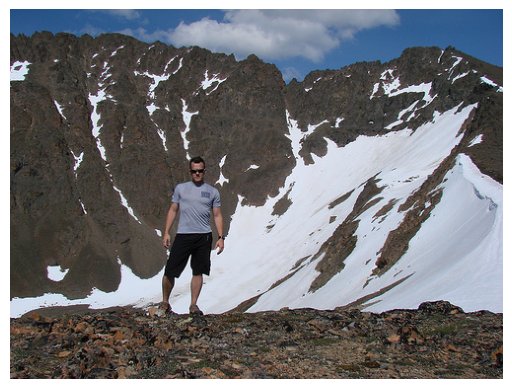

Generated Caption: a person is standing on a snowy mountain
Actual Captions:
- A man in a grey t-shirt standing in front of a snow-covered mountain .
- A man wearing black shorts is standing in front of a snow covered mountain .
- A man wearing glasses stands in front of a snowy mountain .
- A man in a gray shirt and black shorts poses in front of a mountain .

BLEU-1: 0.45489799478447507
BLEU-2: 0.34387056174333663
BLEU-3: 0.23088766101974625
BLEU-4: 0.2918005230159874


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [199]:
test_image_path = "./Flicker8k_Dataset/540338917_57069687be.jpg"
generate_caption_and_evaluate(test_image_path)

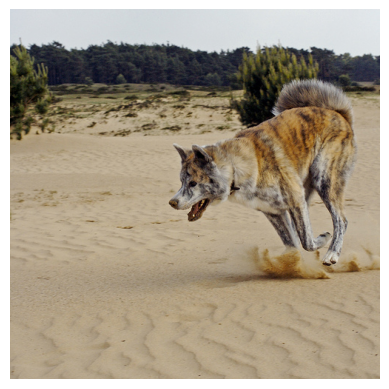

Generated Caption: a dog runs across the sand
Actual Captions:
- A wild dog runs through the desert .
- A striped dog is running in the desert .
- a large brown dog is running across sand dunes in front of some small green foliage .
- A wolf running in sandy plains .

BLEU-1: 0.846481724890614
BLEU-2: 0.3785581357133378
BLEU-3: 0.4976883615946352
BLEU-4: 0.566076446860317


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [122]:
test_image_path = "./Flicker8k_Dataset/506343925_b30a235de6.jpg"
generate_caption_and_evaluate(test_image_path)

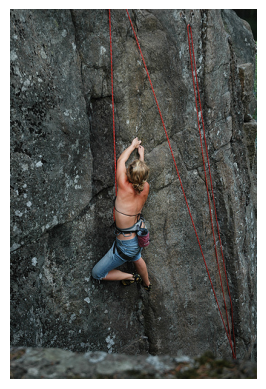

Generated Caption: a man is climbing a rock wall
Actual Captions:
- The woman is holding onto a huge rock and has red string around her .
- A woman climbing a rock cliff .
- A woman in jeans rock climbing .
- Woman goes rock climbing .

BLEU-1: 0.5714285714285714
BLEU-2: 0.4364357804719847
BLEU-3: 0.34016320005192946
BLEU-4: 0.4417918226831577


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [133]:
test_image_path = "./Flicker8k_Dataset/544576742_283b65fa0d.jpg"
generate_caption_and_evaluate(test_image_path)

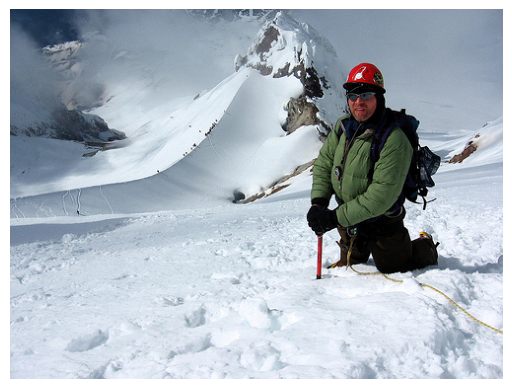

Generated Caption: a person is sitting on a snowy hill
Actual Captions:
- A man measures the depth of snow .
- A man in a green jacket stands in deep snow at the base of a mountain .
- A man crouched on a snowy peak .
- A mountain hiker is digging steaks into the thck snow .

BLEU-1: 0.625
BLEU-2: 0.42257712736425823
BLEU-3: 0.3135508904498039
BLEU-4: 0.4153509237206396


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [125]:
test_image_path = "./Flicker8k_Dataset/485245061_5a5de43e20.jpg"
generate_caption_and_evaluate(test_image_path)